## Import pakages

In [1]:
#!pip install pyodbc
# import packages
# import pyodbc
# import pandas as pd
# import sqlalchemy

In [2]:
# import packages

import pandas as pd
import sqlalchemy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# to remove outliers
from scipy import stats

In [3]:
# Run if using Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# Run if using Google Colab
# !ls /content/drive/MyDrive/TFM/0_PythonScript

## Data Acquisition
I used SQL statements to acquire the AS400 data via the ODBC driver. The codes to acquire the data are saved in the file "dataAcquisitionOdbc.ipynb". Then I saved the acquired datasets to the folders for ease of use.

To sum up, there are 2 datasets in total:
1. Client Dataset: This dataset include all clients' information. There may be duplicated clients or inactive ones, later in the data exploraion and data preprocessing part I will take a closer look at the data.
2. Sales Dataset: This dataset include sales data from the past 5 years (starting from 2016).

## Data Exploration

### Client Dataset Overview

In [5]:
df_client = pd.read_csv('original_data/client.csv')

In [6]:
# Have the first glance of the client dataset
df_client.head()

,Unnamed: 0,ESTADOCLIENTE,CODIGOCLIENTE,CIF,PAGRZ1,PAGRZ2,PROVINCIA,CODIGOGRUPO,NOMBREGRUPO,FECHA_ALTA,FECHA_BAJA
0,0,1,3215.0,A08718736,UNIQUE INTERIM,,BARCELONA,81.0,SESA START,20030116.0,20100712.0
1,1,0,8597.0,B71039002,INSTITUTO CIENTIFICO DE INNOV,Y TECNOLOGIAS APLICADAS,NAVARRA,99999.0,SIN GRUPO,20100128.0,0.0
2,2,0,8417.0,A80652928,"RANDSTAD EMPLEO ETT, S.A.",,MADRID,63.0,RANDSTAD,20090807.0,0.0
3,3,1,9872.0,B82690603,"JOSE CARGE, S.L.",,MADRID,99999.0,SIN GRUPO,20101011.0,20120521.0
4,4,0,30046.0,B17427709,"OIL ALBERA, S.L.",,GIRONA,99999.0,SIN GRUPO,20101013.0,0.0


In [7]:
# Identify column names and variables types
df_client.columns

Index(['Unnamed: 0', 'ESTADOCLIENTE', 'CODIGOCLIENTE', 'CIF', 'PAGRZ1',
       'PAGRZ2', 'PROVINCIA', 'CODIGOGRUPO', 'NOMBREGRUPO', 'FECHA_ALTA',
       'FECHA_BAJA'],
      dtype='object')

In [8]:
df_client.shape

(19683, 11)

In total there are 19683 clients including active and inactive ones.

#### Variable Types
In the SQL statements I already identified and renamed the variables' meanings. To look at them one by one:

**Categorical variables:** 
- EstadoCliente: The status of the client. 0 is active, 1 is inactive.
- CodigoCliente: Client code, this should be unique, if not later in the data processing I will remove duplicates.
- CIF: CIF of the client.
- PAGRZ1, PAGRZ2: These are the business name of the client.
- Provincia: Fiscal province of the client.
- CodigoGrupo: If a client belongs to a group, this column will have group code, if not, then it would be 99999.
- NombreGrupo: Group name.

**DateTime variables:**
- Fecha_Alta: Client opt-in date, the date that a client signed the contract with Up Spain.
- Fecha_Baja: Unsubscribe date, the date that a client ended the contract.

In [9]:
# remove the columns that are not of our interests:
df_client = df_client.drop('Unnamed: 0',axis=1)

In [10]:
df_client.columns

Index(['ESTADOCLIENTE', 'CODIGOCLIENTE', 'CIF', 'PAGRZ1', 'PAGRZ2',
       'PROVINCIA', 'CODIGOGRUPO', 'NOMBREGRUPO', 'FECHA_ALTA', 'FECHA_BAJA'],
      dtype='object')

In [11]:
var_car = ['ESTADOCLIENTE','PROVINCIA','CODIGOGRUPO','NOMBREGRUPO']

In [12]:
for var in var_car:
  df_valuecounts = pd.DataFrame(df_client[var].value_counts())
  df_valuecounts['percentage'] = pd.DataFrame(df_client[var].value_counts()/df_client[var].count())
  print(df_valuecounts.head(10))

   ESTADOCLIENTE  percentage
1          12341    0.626988
0           7342    0.373012
                                  PROVINCIA  percentage
MADRID                                10313    0.523955
BARCELONA                              4815    0.244627
VALENCIA                                877    0.044556
VIZCAYA                                 427    0.021694
SEVILLA                                 279    0.014175
ZARAGOZA                                237    0.012041
MURCIA                                  158    0.008027
PONTEVEDRA                              145    0.007367
ALICANTE                                140    0.007113
VALLADOLID                              135    0.006859
         CODIGOGRUPO  percentage
99999.0        10590    0.538028
5.0              135    0.006859
38.0             127    0.006452
4.0              122    0.006198
57.0             104    0.005284
1.0               96    0.004877
357.0             92    0.004674
728.0             84    0.004268


#### Observations
From the above output, some observations can be concluded:
1. From this client dataset, over 60% of the clients are not active anymore. There are only 7342 active clients. These 7.3K may include duplicates, so later I will first check and remove duplicates. The RFM analysis in the next step will focus on active clients only.
2. Most of the clients are based in Madrid (over 52%) and Barcelona (24%).
3. Most of the clients don't belong to any group (over 53%).
4. The groups with most clients are: COPISA, FCC, DRAGADOS, AUNA, and TELEFONICA.

#### Data Cleaning & Format Correction


1. Create a new column of complete razon social name (PAGRZ1 + PAGRZ2)
2. Seperate client dataset to 2 datasets: one with active clients only, the other with inactive clients only.  
3. Remove duplicated client records from the active client dataset, leave only the latest record.
4. Change and correct data format (dtype).
5. Reformat time series variables.
6. Missing Values (columns PROVINCIA)





In [13]:
# 1. Create a new column of complete razon social name (PAGRZ1 + PAGRZ2)
df_client['RAZONSOCIAL'] = df_client['PAGRZ1'] + df_client['PAGRZ2']
df_client.drop(['PAGRZ1','PAGRZ2'],axis=1,inplace=True)

In [14]:
# 2. Seperate client dataset to 2 datasets: one with active clients only, the other with inactive clients only.
df_client_act = df_client[df_client['ESTADOCLIENTE']==0]
df_client_inact = df_client[df_client['ESTADOCLIENTE']==1]

In [15]:
# 3. Remove duplicated client records from the active client dataset, leave only the latest record.
df_client_act = df_client_act.sort_values('FECHA_ALTA')
df_client_act.drop_duplicates(subset=['CODIGOCLIENTE'],keep='last',inplace=True)

# 4. Change/correct data format
# change dtype to integers
df_client_act[['ESTADOCLIENTE', 'CODIGOCLIENTE', 'CODIGOGRUPO']] = df_client_act[['ESTADOCLIENTE', 'CODIGOCLIENTE', 'CODIGOGRUPO']].astype(int)

# remove blank spaces in string variables
df_client_act['PROVINCIA'] = df_client_act['PROVINCIA'].str.strip()
df_client_act['RAZONSOCIAL'] = df_client_act['RAZONSOCIAL'].apply(lambda x: " ".join(x.split()))
df_client_act['NOMBREGRUPO'] = df_client_act['NOMBREGRUPO'].str.strip()
df_client_act['PROVINCIA'].replace('',np.nan, inplace=True)

# 5. Reformat time series variables.
df_client_act['FECHA_ALTA'] = df_client_act['FECHA_ALTA'].astype(int).astype(str)
df_client_act['FECHA_ALTA'] = pd.to_datetime(df_client_act.FECHA_ALTA, yearfirst=True,infer_datetime_format=True,errors='coerce')

# In the active client dataset, FECHA_BAJA, ESTADOCLIENTE is not important, so remove these from the dataset
df_client_act.drop(['FECHA_BAJA','ESTADOCLIENTE'],axis=1,inplace=True)

In [16]:
df_client_act.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6198 entries, 5236 to 5223
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CODIGOCLIENTE  6198 non-null   int64         
 1   CIF            6198 non-null   object        
 2   PROVINCIA      6193 non-null   object        
 3   CODIGOGRUPO    6198 non-null   int64         
 4   NOMBREGRUPO    6198 non-null   object        
 5   FECHA_ALTA     6198 non-null   datetime64[ns]
 6   RAZONSOCIAL    6198 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 387.4+ KB


In [17]:
# 6. Missing values: Because the mode value in column PROVINCIA is Madrid, I'm going to replace missing values with value 'MADRID'
df_client_act['PROVINCIA'].fillna("MADRID",inplace=True)

### Sales Dataset Overview

In [18]:
df_sales = pd.read_csv('original_data/sales.csv')

In [19]:
# Have the first glance of the client dataset
df_sales.head()

,Unnamed: 0,Unnamed: 0.1,FACNUM,FACFEC,FACBRU,FACCOM,FACIVA,FACNET,FACCLI,FACTRA,TIPO_PRODUCTO
0,0,0,D020823,20210607.0,-639.0,0.00,0.00,-639.00,7439.0,0.0,ChequeGourmet
1,1,1,F000251,20210607.0,-2.0,0.00,-0.42,-2.42,1563.0,0.0,ChequeGourmet
2,2,2,T001655,20210607.0,-5.0,0.00,-1.05,-6.05,1563.0,0.0,ChequeGourmet
3,3,3,0104845,20210607.0,21743.0,0.00,0.00,21743.00,2382.0,0.0,ChequeGourmet
4,4,4,0104846,20210607.0,792.0,25.74,6.88,831.62,3475.0,5.0,ChequeGourmet


In [20]:
df_sales.describe()

,Unnamed: 0,Unnamed: 0.1,FACFEC,FACBRU,FACCOM,FACIVA,FACNET,FACCLI,FACTRA
count,408687.00000,408687.00000,4.086870e+05,4.086870e+05,408687.000000,408687.000000,4.086870e+05,408687.000000,408687.000000
mean,204343.00000,204343.00000,2.018389e+07,2.312540e+03,18.125890,4.312679,2.336466e+03,13215.627377,0.811438
std,117977.91907,117977.91907,1.536143e+04,8.307745e+04,452.102706,95.766805,8.322998e+04,6806.668721,9.689894
min,0.00000,0.00000,2.016010e+07,-3.465000e+07,-199999.980000,-42000.000000,-3.465000e+07,0.000000,-1039.500000
25%,102171.50000,102171.50000,2.017070e+07,9.600000e+01,0.000000,0.000000,1.000000e+02,10299.000000,0.000000
50%,204343.00000,204343.00000,2.018112e+07,3.840000e+02,3.300000,1.160000,3.936000e+02,13673.000000,0.000000
75%,306514.50000,306514.50000,2.020011e+07,1.338000e+03,15.300000,3.795000,1.367715e+03,16056.000000,0.000000
max,408686.00000,408686.00000,2.021061e+07,3.465000e+07,199999.980000,42000.000000,3.465000e+07,80001.000000,3320.000000


In [21]:
df_sales.shape

(408687, 11)

In [22]:
df_sales.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'FACNUM', 'FACFEC', 'FACBRU', 'FACCOM',
       'FACIVA', 'FACNET', 'FACCLI', 'FACTRA', 'TIPO_PRODUCTO'],
      dtype='object')

#### Variable Types
**Categorical variables:** 
- FACNUM: Invoice number
- FACCLI: Client code
- TIPO_PRODUCTO: Product type purchased in the invoice.


**Numerical variables:**
- FACBRU: Subtotal sales value
- FACCOM: Commission
- FACIVA: IVA (tax)
- FACNET: Total sales value (FACBRU + FACCOM + IVA)
- FACTRA: Shipping Cost

**DateTime variables:**
- FACFEC: Billing Date



In [23]:
# remove the column that is not of my interests
df_sales = df_sales.drop('Unnamed: 0',axis=1)

#### Data Visualization

Numerical Variables:

In [24]:
# Select columns that are of my interest:
var_num = ['FACBRU','FACCOM','FACIVA','FACNET','FACTRA']

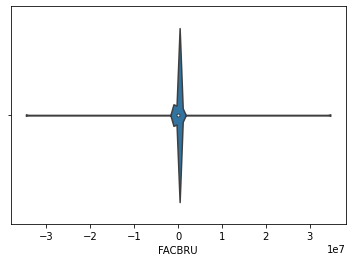

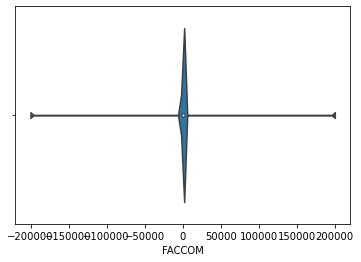

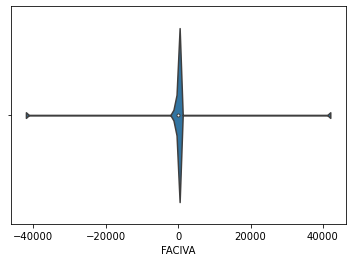

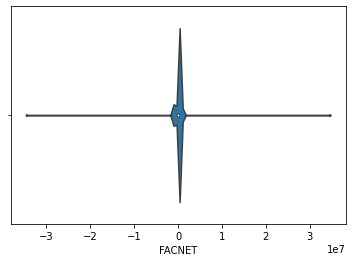

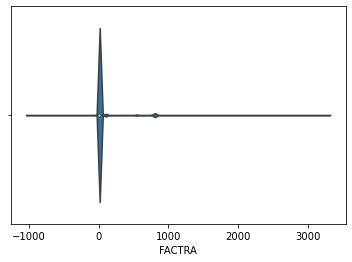

<Figure size 432x288 with 0 Axes>

In [25]:
for var in var_num:
  sns.violinplot(x=df_sales[var]) 
  plt.figure()

In [26]:
for var in var_num:
  df_valuecounts = pd.DataFrame(df_sales[var].value_counts())
  df_valuecounts['percentage'] = pd.DataFrame(df_sales[var].value_counts()/df_sales[var].count())
  print(df_valuecounts.head(10))

       FACBRU  percentage
2.0      8645    0.021153
3.0      5576    0.013644
180.0    5109    0.012501
0.0      4096    0.010022
200.0    3328    0.008143
220.0    3190    0.007805
360.0    2896    0.007086
100.0    2866    0.007013
300.0    2667    0.006526
4.0      1937    0.004740
      FACCOM  percentage
0.0   135920    0.332577
10.0   22767    0.055708
1.8     1400    0.003426
15.0    1233    0.003017
18.0    1137    0.002782
3.0     1097    0.002684
1.0     1052    0.002574
0.9     1048    0.002564
2.0     1031    0.002523
1.5     1003    0.002454
      FACIVA  percentage
0.00  101455    0.248246
2.52   14444    0.035342
0.42    7673    0.018775
2.10    6233    0.015251
3.57    5221    0.012775
0.63    4699    0.011498
1.05    4154    0.010164
1.47    3694    0.009039
1.68    3407    0.008336
0.84    2265    0.005542
        FACNET  percentage
2.42      5081    0.012432
3.63      3328    0.008143
8.47      2511    0.006144
9.68      2440    0.005970
12.10     1789    0.004377
6.

Categorical Variables

<Figure size 432x288 with 0 Axes>

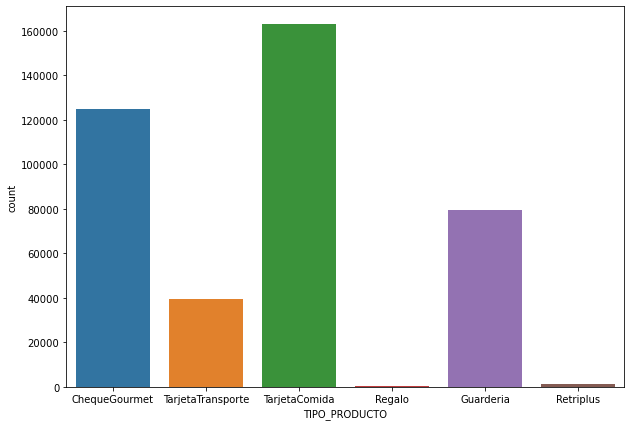

<Figure size 432x288 with 0 Axes>

In [27]:
# Select columns that are of my interest: Only 1 categorical variable (Payment Type)
var_car = 'TIPO_PRODUCTO'

f, axes = plt.subplots(figsize=(10, 7),sharex=True)
sns.countplot(x=df_sales[var_car])
plt.figure()

In [28]:
df_valuecounts = pd.DataFrame(df_sales[var_car].value_counts())
df_valuecounts['percentage'] = pd.DataFrame(df_sales[var_car].value_counts()/df_sales[var_car].count())
df_valuecounts.head(10)

,TIPO_PRODUCTO,percentage
TarjetaComida,162862,0.398501
ChequeGourmet,124962,0.305765
Guarderia,79677,0.194958
TarjetaTransporte,39459,0.096551
Retriplus,1174,0.002873
Regalo,553,0.001353


#### Observations

From the above output, some observations can be concluded: 
1. From the data visualization, I see that there are outliers in the numerical variables, so later I will remove the outliers.
2. The products that are mostly purchased are *Tarjeta Comida*, *Cheque Comida* and *Guarderia*. These 3 products take up nearly 90% of the invoices. Later after the step of data cleaning and format correction, I will further investigate on the sales per product type.


#### Data Cleaning & Format Correction

1. Change and correct data format (dtype).
2. Reformat time series variables.
3. Remove outliers from numerical variables.

In [29]:
# Change data format (dtype)

# change dtype to integers
df_sales['FACCLI'] = df_sales['FACCLI'].astype(int)

# Reformat time series variables.
df_sales['FACFEC'] = df_sales['FACFEC'].astype(int).astype(str)
df_sales['FACFEC'] = pd.to_datetime(df_sales.FACFEC, yearfirst=True,infer_datetime_format=True,errors='coerce')

# Remove outliers from numerical variables.

df_sales = df_sales[(np.abs(stats.zscore(df_sales[['FACBRU','FACCOM','FACIVA','FACNET','FACTRA']])) < 3).all(axis=1)]

In [30]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407639 entries, 0 to 408686
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Unnamed: 0.1   407639 non-null  int64         
 1   FACNUM         407639 non-null  object        
 2   FACFEC         407639 non-null  datetime64[ns]
 3   FACBRU         407639 non-null  float64       
 4   FACCOM         407639 non-null  float64       
 5   FACIVA         407639 non-null  float64       
 6   FACNET         407639 non-null  float64       
 7   FACCLI         407639 non-null  int64         
 8   FACTRA         407639 non-null  float64       
 9   TIPO_PRODUCTO  407639 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 34.2+ MB


#### Special Invoice
Now that both datasets are clean and the format of each column was all corrected. Before combining the 2 datasets using a right join, I need to create an additional column identifying the **Special Invoice**.


If an invoice number starts with alphabet (ABCD...etc.), it is a special invoice, which is most likely a cancelled invoice or it's a specific case when  Up Spain has to return the clients money. In the calculation of Recency and Frequency, I'm only interested in the invoice that comes from the clients' orders, so I don't want to take into these special invoice into account. In order to easily identify these kind of invoice. That's why I have to create an additional column in the df_all dataframe.

In [31]:
# Create a function to identify special invoices.
def special(x):
  num_list = list(map(str,range(0,10,1)))
  if x[0] not in num_list:
    return 1
  else:
    return 0

In [32]:
specialInvoice = df_sales['FACNUM'].apply(special)
df_sales.insert(1,'SpecialInvoice',specialInvoice)

### Merged Datasets Overview

In [33]:
df_all = df_sales.merge(df_client_act,how='right',left_on='FACCLI',right_on='CODIGOCLIENTE')
df_all.drop('FACCLI',axis=1,inplace=True)
df_all.head()

,Unnamed: 0.1,SpecialInvoice,FACNUM,FACFEC,FACBRU,FACCOM,FACIVA,FACNET,FACTRA,TIPO_PRODUCTO,CODIGOCLIENTE,CIF,PROVINCIA,CODIGOGRUPO,NOMBREGRUPO,FECHA_ALTA,RAZONSOCIAL
0,43692.0,1.0,D019618,2020-11-25,-799.20,0.00,0.00,-799.20,0.0,ChequeGourmet,14,A28461994,MADRID,6,EUROPE ASSISTANCE,1992-04-21,"EUROP ASSISTANCE ESPAÑA, S.A."
1,86793.0,1.0,D100593,2020-03-02,-8.15,0.00,0.00,-8.15,0.0,TarjetaComida,14,A28461994,MADRID,6,EUROPE ASSISTANCE,1992-04-21,"EUROP ASSISTANCE ESPAÑA, S.A."
2,99109.0,1.0,O012255,2020-01-21,-233.10,-2.33,-0.49,-235.92,0.0,ChequeGourmet,14,A28461994,MADRID,6,EUROPE ASSISTANCE,1992-04-21,"EUROP ASSISTANCE ESPAÑA, S.A."
3,99110.0,1.0,O012256,2020-01-21,-510.60,-5.11,-1.07,-516.78,0.0,ChequeGourmet,14,A28461994,MADRID,6,EUROPE ASSISTANCE,1992-04-21,"EUROP ASSISTANCE ESPAÑA, S.A."
4,99111.0,1.0,O012257,2020-01-21,-699.30,-6.99,-1.47,-707.76,0.0,ChequeGourmet,14,A28461994,MADRID,6,EUROPE ASSISTANCE,1992-04-21,"EUROP ASSISTANCE ESPAÑA, S.A."


In [34]:
print(df_all['CODIGOCLIENTE'].nunique(),df_all.shape)

6198 (267651, 17)


In [35]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267651 entries, 0 to 267650
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Unnamed: 0.1    264846 non-null  float64       
 1   SpecialInvoice  264846 non-null  float64       
 2   FACNUM          264846 non-null  object        
 3   FACFEC          264846 non-null  datetime64[ns]
 4   FACBRU          264846 non-null  float64       
 5   FACCOM          264846 non-null  float64       
 6   FACIVA          264846 non-null  float64       
 7   FACNET          264846 non-null  float64       
 8   FACTRA          264846 non-null  float64       
 9   TIPO_PRODUCTO   264846 non-null  object        
 10  CODIGOCLIENTE   267651 non-null  int64         
 11  CIF             267651 non-null  object        
 12  PROVINCIA       267651 non-null  object        
 13  CODIGOGRUPO     267651 non-null  int64         
 14  NOMBREGRUPO     267651 non-null  obj

Now I have a merged dataset with 6198 unique clients and 267651 billing records.

#### Lost Clients 
- There are 2715 clients that have never made purchase these past 5 years. I will remove these people from the dataframe and assign them as "Lost Client".
- Based on the suggestion given by Up Spain, clients that have never made purchased for more than 15 months should be considered as "Lost Client" as well.


In [36]:
lost_client = df_all[df_all['FACNUM'].isnull()].CODIGOCLIENTE
df_all.dropna(inplace=True)
df_all.drop("Unnamed: 0.1", axis=1, inplace=True)

## K-Means Client Segmentation with RFM Variables
RFM Analysis is a technique to create client segments based on the three key purchase-behavior variables: 

1. **Recency** - Time since last purchase. 
In the Data Preparation section, I will create a variable that indicates the duration (in day) since their last purchase.
2. **Frequency** - The frequency of the client transactions or visists. In this case I will create a new variable and calculate the average days between purchases as frequency.
3. **Monetary value** - The intention of client to spend or purchasing power of client. Here I will create 2 variables: One is the total spend per year and the other is the average spend per invoice using the variable 'FACBRU' (nominal value) in the dataset.




### Data Preparation
In this section, I will prepare the dataset in order to further carry out the RFM analysis. The main objective is to create necessary variables for the analysis.

In [37]:
df_all.head()

,SpecialInvoice,FACNUM,FACFEC,FACBRU,FACCOM,FACIVA,FACNET,FACTRA,TIPO_PRODUCTO,CODIGOCLIENTE,CIF,PROVINCIA,CODIGOGRUPO,NOMBREGRUPO,FECHA_ALTA,RAZONSOCIAL
0,1.0,D019618,2020-11-25,-799.20,0.00,0.00,-799.20,0.0,ChequeGourmet,14,A28461994,MADRID,6,EUROPE ASSISTANCE,1992-04-21,"EUROP ASSISTANCE ESPAÑA, S.A."
1,1.0,D100593,2020-03-02,-8.15,0.00,0.00,-8.15,0.0,TarjetaComida,14,A28461994,MADRID,6,EUROPE ASSISTANCE,1992-04-21,"EUROP ASSISTANCE ESPAÑA, S.A."
2,1.0,O012255,2020-01-21,-233.10,-2.33,-0.49,-235.92,0.0,ChequeGourmet,14,A28461994,MADRID,6,EUROPE ASSISTANCE,1992-04-21,"EUROP ASSISTANCE ESPAÑA, S.A."
3,1.0,O012256,2020-01-21,-510.60,-5.11,-1.07,-516.78,0.0,ChequeGourmet,14,A28461994,MADRID,6,EUROPE ASSISTANCE,1992-04-21,"EUROP ASSISTANCE ESPAÑA, S.A."
4,1.0,O012257,2020-01-21,-699.30,-6.99,-1.47,-707.76,0.0,ChequeGourmet,14,A28461994,MADRID,6,EUROPE ASSISTANCE,1992-04-21,"EUROP ASSISTANCE ESPAÑA, S.A."


In [38]:
# Create Billing Year column ('FACYEAR') to better organize and analyze the data
year = pd.DatetimeIndex(df_all['FACFEC']).year
df_all.insert(2, 'FACYEAR', year)
df_all.tail()

,SpecialInvoice,FACNUM,FACYEAR,FACFEC,FACBRU,FACCOM,FACIVA,FACNET,FACTRA,TIPO_PRODUCTO,CODIGOCLIENTE,CIF,PROVINCIA,CODIGOGRUPO,NOMBREGRUPO,FECHA_ALTA,RAZONSOCIAL
267643,0.0,1109463,2021,2021-05-18,882.99,0.00,0.00,882.99,0.0,TarjetaComida,18835,B02964989,BARCELONA,1600,MERCER PLANETA,2021-05-13,OBS FORMACIÓN ONLINE EN MANAGEMENT S.L.
267644,0.0,6104611,2021,2021-05-14,312.66,1.09,0.23,313.98,0.0,Guarderia,18835,B02964989,BARCELONA,1600,MERCER PLANETA,2021-05-13,OBS FORMACIÓN ONLINE EN MANAGEMENT S.L.
267645,0.0,2101489,2021,2021-06-05,89.00,3.12,0.66,92.78,0.0,TarjetaTransporte,18856,02660462Y,HUESCA,99999,SIN GRUPO,2021-05-26,CRISTINA CID AGUILAR
267646,0.0,2101410,2021,2021-05-28,3.00,0.00,1.68,9.68,5.0,TarjetaTransporte,18856,02660462Y,HUESCA,99999,SIN GRUPO,2021-05-26,CRISTINA CID AGUILAR
267650,1.0,Q146452,2021,2021-06-03,209.00,0.00,0.00,209.00,0.0,TarjetaComida,18868,B22183370,ZARAGOZA,813,MERCER URBASER,2021-05-31,"ARQUISOCIAL, S.L."


#### **Recency**

In order to create a variable that indicates the duration (in day) since their last purchase, I have to find out the last purchase date of each client and calculate the difference from today (Jun 15, 2021).

Note: Here I'm only interested in **Standard Invoice**, so I won't take into account the special invoice.

In [39]:
df_lastpurchase = df_all[['CODIGOCLIENTE','FACFEC']][df_all['SpecialInvoice']==0].sort_values('FACFEC').drop_duplicates(subset=['CODIGOCLIENTE'], keep='last', inplace=False)
df_lastpurchase.columns = ['CODIGOCLIENTE','LastPurchaseDate']

today = pd.to_datetime('today').normalize()

df_lastpurchase['Recency'] = abs((df_lastpurchase['LastPurchaseDate'] - today).dt.days)

df_all = df_all.merge(df_lastpurchase, how='left',on=['CODIGOCLIENTE'])
df_all.sort_values('FACFEC',ascending=False).head()

,SpecialInvoice,FACNUM,FACYEAR,FACFEC,FACBRU,FACCOM,FACIVA,FACNET,FACTRA,TIPO_PRODUCTO,CODIGOCLIENTE,CIF,PROVINCIA,CODIGOGRUPO,NOMBREGRUPO,FECHA_ALTA,RAZONSOCIAL,LastPurchaseDate,Recency
34425,0.0,0104850,2021,2021-06-07,180.00,0.0,0.00,180.00,0.0,ChequeGourmet,6389,A48084909,LAS PALMAS,4,DRAGADOS,2007-06-13,"OPERACIONES PORTUARIAS CANARIAS,S.A.",2021-06-07,10.0
29997,1.0,D111305,2021,2021-06-07,-542.96,0.0,0.00,-542.96,0.0,TarjetaComida,5572,B81746257,MADRID,993,SERMES,2006-08-01,SERMES PLANIFICACION,2021-05-26,22.0
143789,1.0,D111343,2021,2021-06-07,-6005.53,0.0,0.00,-6005.53,0.0,TarjetaComida,11877,A08503005,BARCELONA,682,GALLINA BLANCA,2014-10-03,"THE GB FOODS, S.A.",2021-05-31,17.0
141897,1.0,D111351,2021,2021-06-07,-3639.31,0.0,0.00,-3639.31,0.0,TarjetaComida,12716,A46205431,VALENCIA,405,DOMINGUIS,2014-08-26,"FALCK SCI, S.A",2021-05-11,37.0
138817,1.0,Q205651,2021,2021-06-07,155.00,3.1,0.65,158.75,0.0,TarjetaTransporte,13031,A28985992,MADRID,929,COMPENSACH SEUR,2014-05-13,SEUR S.A.,2021-05-18,30.0


In [40]:
df_lastpurchase.shape

(3309, 3)

#### **Frequency**
The frequency of the client transactions or visists. In this case I will create a new variable and calculate the average days between invoice dates as frequency. So the lower the more preferable.

Note:

1. If several invoices are issued at the same day from a client, I remove duplicates and only leave 1 date to indicate the purchase date. So the result of the average purchase frequency is more accurate and objective.

2. Here I'm only interested in **Standard Invoice**, so I won't take into account the special invoice.


In [41]:
df_frequency = df_all[['CODIGOCLIENTE','FACFEC']][df_all['SpecialInvoice']==0].sort_values(['CODIGOCLIENTE','FACFEC'])

# If several invoices are issued at the same day, I only want to count them as 1 Purchase:
def func(df):
  for i in df['CODIGOCLIENTE'].unique():
    df[df['CODIGOCLIENTE']==i] = df[df['CODIGOCLIENTE']==i].drop_duplicates('FACFEC')
  return df

df_frequency = func(df_frequency)

df_frequency['LastInvoiceDate'] = df_frequency.groupby('CODIGOCLIENTE')['FACFEC'].shift()
df_frequency['Frequency'] = (df_frequency['FACFEC'] - df_frequency['LastInvoiceDate']).dt.days
df_frequency = df_frequency[['CODIGOCLIENTE','Frequency']].groupby('CODIGOCLIENTE',as_index=False).mean().round(2)

df_all = df_all.merge(df_frequency, how='left',on='CODIGOCLIENTE')

#### **Monetary Value**

The Monetary Value is the intention of the clients to spend or purchasing power of the clients. I will create the variable "Average Annual Income" to indicate the Monetary Value of clients.

Note: Regarding the variable *Average Annual Income*, I only take into account the sales from year 2018-2020 so that the result could reflect more the recent reality. 2021 hasn't ended so I will not take it into account either.


In [42]:
# Average Annual Income of a client
df_mvalue = df_all[['CODIGOCLIENTE','FACYEAR','FACNUM','FACNET','FACBRU','FACIVA']][(df_all['FACYEAR']>=2018) & (df_all['FACYEAR']<2021)].copy()
df_mvalue['Monetary'] = (df_mvalue['FACNET'] - df_mvalue['FACBRU'] - df_mvalue['FACIVA']).round(2)
df_mvalue = df_mvalue[['CODIGOCLIENTE','FACYEAR','Monetary']].groupby(['CODIGOCLIENTE','FACYEAR'],as_index=False).sum().groupby('CODIGOCLIENTE', as_index=False).mean().round(2).drop('FACYEAR',axis=1)

# Merge this variable with the df_all dataframe
df_all = df_all.merge(df_mvalue,how='left',on='CODIGOCLIENTE')


Now that we have the variables in order to carry out the RFM analysis.

In [43]:
df_rfm = df_all[['CODIGOCLIENTE','Recency','Frequency','Monetary']].drop_duplicates('CODIGOCLIENTE').sort_values('CODIGOCLIENTE').reset_index(drop=True)
df_rfm.head()

,CODIGOCLIENTE,Recency,Frequency,Monetary
0,1,23.0,16.54,473.48
1,3,722.0,11.90,0.00
2,8,565.0,17.81,57.50
3,14,525.0,14.89,1055.08
4,32,20.0,21.23,858.08


In [44]:
df_rfm.describe()

,CODIGOCLIENTE,Recency,Frequency,Monetary
count,3393.000000,3309.000000,3169.000000,2900.000000
mean,12480.033599,437.759746,50.967242,355.457159
std,7399.894043,560.595463,69.863479,674.660517
min,1.000000,10.000000,1.000000,-5.690000
25%,7778.000000,24.000000,21.040000,29.717500
50%,11949.000000,114.000000,30.400000,141.885000
75%,16581.000000,647.000000,47.110000,396.445000
max,80001.000000,1991.000000,1056.000000,11371.050000


#### Visualize the Variables

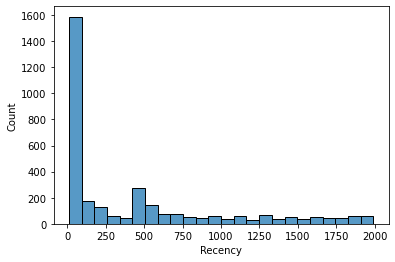

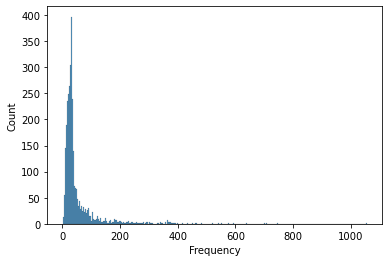

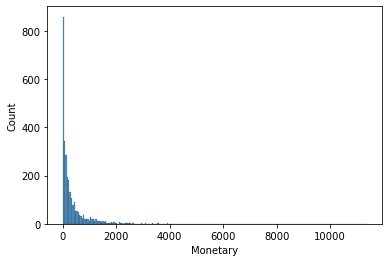

<Figure size 432x288 with 0 Axes>

In [45]:
for i in df_rfm.columns[1:]:
  sns.histplot(x = df_rfm[i])
  plt.figure()

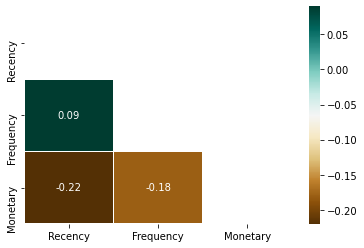

In [46]:
corr = round(df_rfm.iloc[:,1:5].corr(),2)
corr = corr.mask(np.triu(np.ones(corr.shape)).astype(np.bool))

fig, ax = plt.subplots()

sns.heatmap(corr, annot=True, linewidths=.5,ax=ax, cmap='BrBG')
plt.show()

From the correlation matrix above, it can be observed that Monetary variable and the other 2 variables *Recency & Frequency* are quite correlated, with -0.22 and -0.18 correlation coefficients respectively. This indicates that:
- Clients who purchased recently have higher monetary value as well.
- Clients who purchase relatively less frequently generate higher income for thie business.

### Client Segmentation

Now the dataset df_rfm is ready for me create clients segmentations based on these variables.

I will assign score from 1 to 4 (4 is the most preferable) in each rfm variable using quantiles, then create client segmentations based on the following criteria:

1. **Key Clients:** High Recency(4), High frequency(4), High Monetary Value(4)
2. **Frequent Buyers:** High frequency(4)
3. **Lost Clients:** Low Recency(1)
4. **High Value Clients:** High Monetary Value(4)

In [47]:
df_rfm.head()

,CODIGOCLIENTE,Recency,Frequency,Monetary
0,1,23.0,16.54,473.48
1,3,722.0,11.90,0.00
2,8,565.0,17.81,57.50
3,14,525.0,14.89,1055.08
4,32,20.0,21.23,858.08


In [48]:
quantiles = df_rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'CODIGOCLIENTE': {0.25: 7778.0, 0.5: 11949.0, 0.75: 16581.0},
 'Recency': {0.25: 24.0, 0.5: 114.0, 0.75: 647.0},
 'Frequency': {0.25: 21.04, 0.5: 30.4, 0.75: 47.11},
 'Monetary': {0.25: 29.7175, 0.5: 141.885, 0.75: 396.44500000000005}}

In [49]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [50]:
df_rfm_score = df_rfm.copy()
df_rfm_score['R_Score'] = df_rfm_score['Recency'].apply(RScore, args=('Recency',quantiles))
df_rfm_score['F_Score'] = df_rfm_score['Frequency'].apply(RScore, args=('Frequency',quantiles))
df_rfm_score['M_Score'] = df_rfm_score['Monetary'].apply(FMScore, args=('Monetary',quantiles))
df_rfm_score['RFM_Score'] = df_rfm_score['R_Score'] + df_rfm_score['F_Score'] + df_rfm_score['M_Score']
df_rfm_score.head(10)

,CODIGOCLIENTE,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,1,23.0,16.54,473.48,4,4,4,12
1,3,722.0,11.90,0.00,1,4,1,6
2,8,565.0,17.81,57.50,2,4,2,8
3,14,525.0,14.89,1055.08,2,4,4,10
4,32,20.0,21.23,858.08,4,3,4,11
5,68,16.0,29.48,367.21,4,3,3,10
6,88,91.0,35.38,199.10,3,2,3,8
7,98,NaN,NaN,0.00,1,1,1,3
8,114,24.0,21.27,1583.36,4,3,4,11
9,119,NaN,NaN,NaN,1,1,4,6


Now that I have the score for each variable, I can check how many clients are in each segments I defined:

1. **Key Clients:** High Recency(4), High frequency(4), High Monetary Value(4)

2. **Frequent Buyers:** High frequency(4)

3. **Lost Clients:** Low Recency(1) & Those whose last order was more than 15 months ago (according to Up Spain's definition.)

4. **High Value Clients:** High Monetary Value(4)

In [51]:
print("Out of",df_rfm_score['CODIGOCLIENTE'].nunique(),"clients:")
print("Key Clients:",len(df_rfm_score[(df_rfm_score['R_Score']==4) & (df_rfm_score['F_Score']==4)&(df_rfm_score['M_Score']==4)]))
print('Frequent Buyers: ',len(df_rfm_score[df_rfm_score['F_Score']==4]))
print("Lost Clients:",len(df_rfm_score[(df_rfm_score['R_Score']==1) | (df_rfm_score['Recency']>180)]))
print('High Value Clients:', len(df_rfm_score[df_rfm_score['M_Score']==4]))

Out of 3393 clients:
Key Clients: 210
Frequent Buyers:  793
Lost Clients: 1611
High Value Clients: 1218


In [52]:
df_rfm_score['RFM_Score'].unique()
df_rfm_score.groupby('RFM_Score',as_index=False).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CODIGOCLIENTE':"count"}).sort_values('RFM_Score',ascending=False).round(2)

,RFM_Score,Recency,Frequency,Monetary,CODIGOCLIENTE
9,12,17.16,13.73,1496.92,210
8,11,25.83,18.68,929.78,267
7,10,76.61,22.47,544.37,316
6,9,257.94,26.00,321.78,390
5,8,494.14,31.21,236.75,468
4,7,558.77,43.99,142.64,504
3,6,800.67,79.19,97.18,573
2,5,482.02,93.12,57.95,339
1,4,663.54,123.62,27.12,227
0,3,1015.70,187.87,7.59,99


### K-Means Clustering with RFM Variables



#### Data Proprocessing
As K-means gives the best result under the conditions when:

1. Missing data: Before applying K-Means, I will remove missing values.


2. Data's distribution is not skewed --> Perform log transformation.

3. Data is standardised (mean equals to 0 and standard deviation equals to 1) --> Perform data standardization.

In [53]:
# Check missing data in the df_rfm dataframe
df_rfm.isna().sum()

CODIGOCLIENTE      0
Recency           84
Frequency        224
Monetary         493
dtype: int64

I will remove the clients with NaNs from the data frame because:

1. If Recency & Frequency is missing, it indicates that there's no *last standard purchase information* from this client, which means there are only Special Invoices from this client.
2. If Frequency is missing, it's because there's no order/purchase made during the period 2018 - 2020. These clients wouldn't be of my interests either. So remove them from the df.

In [54]:
# Drop missing values
df_rfm.dropna(inplace=True)

In [55]:
# Define a formula to check if the distribution of a variable is skewed
def checkSkewed(df, column):
  skew = stats.skew(df[column],nan_policy='omit')
  plt.title('Distribution of ' + column)
  sns.distplot(df[column])
  print("{}'s: Skew: {}".format(column, skew))
  return

,CODIGOCLIENTE,Recency,Frequency,Monetary
0,1,23.0,16.54,473.48
1,3,722.0,11.90,0.00
2,8,565.0,17.81,57.50
3,14,525.0,14.89,1055.08
4,32,20.0,21.23,858.08


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

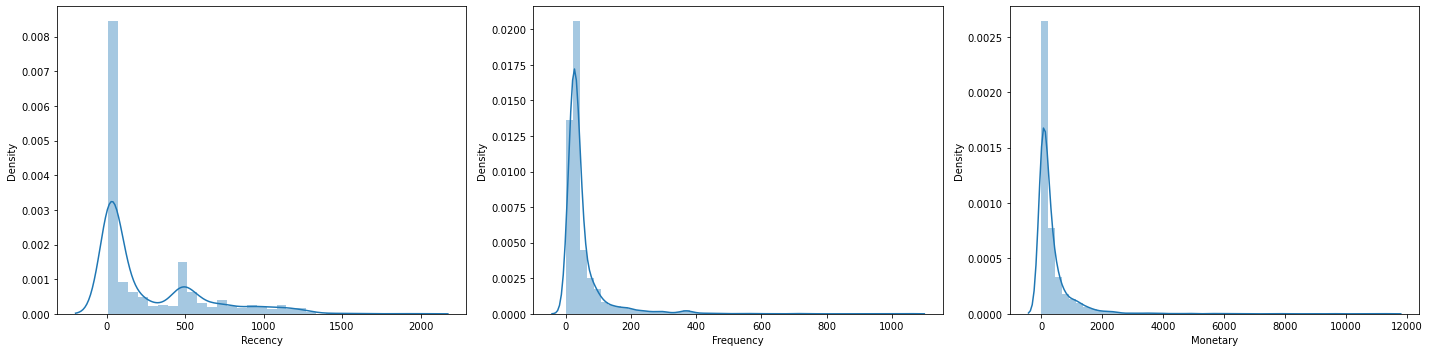

In [73]:
# Plot all 3 graphs together for summary findings

fig, axes = plt.subplots(1,3,figsize = (20,5))
for i, feature in enumerate(list(df_rfm.drop('CODIGOCLIENTE',axis=1).columns)):
    sns.distplot(df_rfm[feature],ax=axes[i])

plt.tight_layout()
plt.savefig('images/before_transform.png', format='png', dpi=1000)

The variables are very skewed, so I will perform log transformations to reduce the skewness of each variable. 
In the Monetary variable, there are negative values, so I will add a constant value 3 to the data prior to applying the log transformation.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

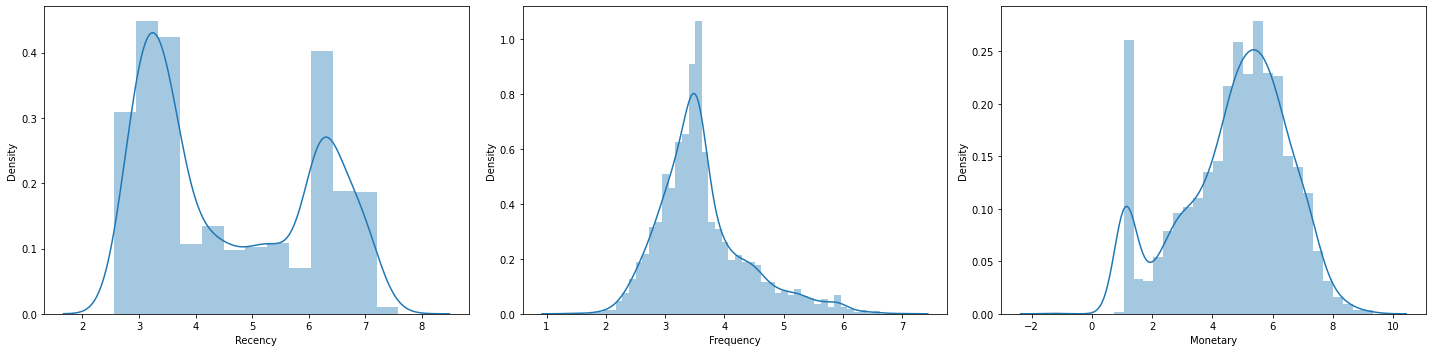

In [75]:
df_rfm_log = df_rfm.copy()
df_rfm_log.iloc[:,1:] = np.log(df_rfm_log.iloc[:,1:]+3)

# Visualizae the data after log transformation

fig, axes = plt.subplots(1,3,figsize = (20,5))
for i, feature in enumerate(list(df_rfm_log.drop('CODIGOCLIENTE',axis=1).columns)):
    sns.distplot(df_rfm_log[feature],ax=axes[i])

plt.tight_layout()
plt.savefig('images/after_transform.png', format='png', dpi=1000)

In [58]:
# Data Normalization
scaler = StandardScaler()

df_rfm_clientcode = pd.DataFrame(df_rfm_log.sort_values("CODIGOCLIENTE").reset_index(drop=True)['CODIGOCLIENTE'], columns = ['CODIGOCLIENTE'])
df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm_log.sort_values("CODIGOCLIENTE").reset_index(drop=True).iloc[:,1:]),columns=['Recency', 'Frequency', 'Monetary'])

df_rfm_scaled_new = pd.concat([df_rfm_clientcode,df_rfm_scaled],axis=1)
print(df_rfm_clientcode.shape,df_rfm_scaled.shape,df_rfm_scaled_new.shape)

(2824, 1) (2824, 3) (2824, 4)


In [59]:
df_rfm_scaled = df_rfm_scaled_new.copy()

#### Determine the Optimal K for K-Means
Next I will apply **The Elbow Method** to find the optimal K:

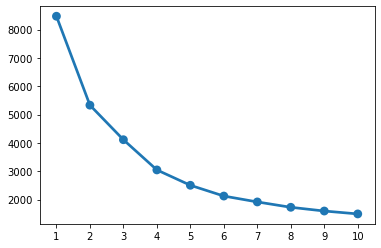

In [60]:
# SSE = Error Sum of Squares
SSE = []

for k in range(0,10):
  kmeans=KMeans(n_clusters=k+1,init = 'k-means++',random_state=1200).fit(df_rfm_scaled.iloc[:,1:])
  SSE.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,11)),y=SSE)
plt.show()

From the plot above, it can be observed that the optimal number of clusters is 4 or 5.

In [61]:
# finding the clusters based on input

model = KMeans(n_clusters=4,init = "k-means++", max_iter = 300, n_init = 10, random_state=1200)
y_clusters = model.fit_predict(df_rfm_scaled.iloc[:,1:])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

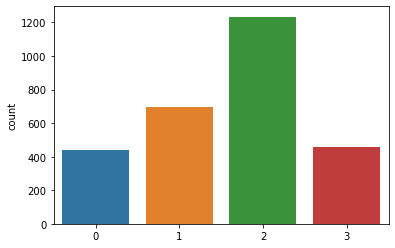

In [62]:
# countplot to check the number of clusters and number of clients in each cluster

sns.countplot(y_clusters)

In [63]:
y_clusters.shape

(2824,)

From this chart we can see that there are more number of customers in the cluster 2.

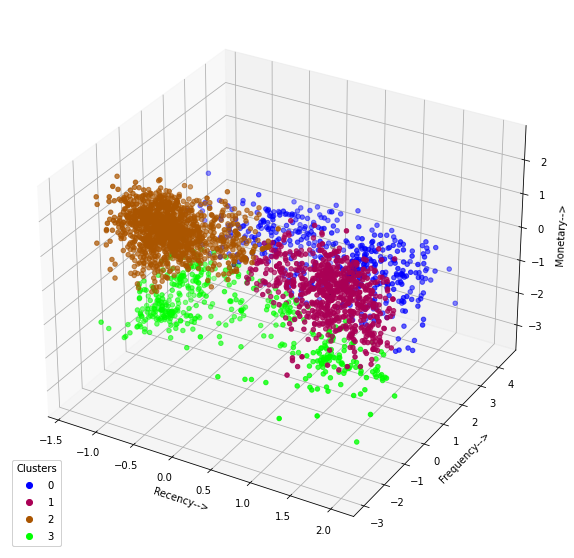

In [71]:
# 3D scatterplot using matplotlib

centers=model.cluster_centers_
fig=plt.figure(figsize=(10,10))

x = df_rfm_scaled['Recency']
y = df_rfm_scaled['Frequency']
z = df_rfm_scaled['Monetary']

ax=fig.add_subplot(projection='3d')
scatter = ax.scatter(x,y,z,cmap='brg',c=model.predict(df_rfm_scaled.iloc[:,1:]))
ax.set_xlabel('Recency-->')
ax.set_ylabel('Frequency-->')
ax.set_zlabel('Monetary-->')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend1)

ax.scatter(centers[:,0],centers[:,1],c='black')

Now that I have the visualization of the 4 clusters, I'm going to identify the clusters for further analysis:

In [81]:
df_rfm_scaled = df_rfm_scaled.set_index('CODIGOCLIENTE')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


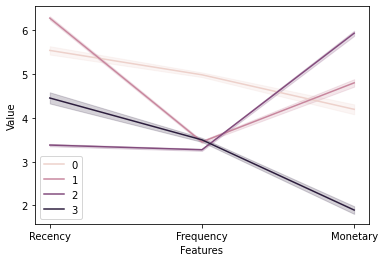

In [86]:
rfm = pd.DataFrame(scaler.inverse_transform(df_rfm_scaled))
rfm.columns = df_rfm_scaled.columns
rfm['ClientID'] = df_rfm_scaled.index
rfm['Cluster'] = model.labels_

melted_rfm_scaled = pd.melt(rfm.reset_index(),
                    id_vars=["ClientID","Cluster"],
                    value_vars=['Recency',"Frequency","Monetary"],
                    var_name="Features",
                    value_name="Value")

sns.lineplot('Features','Value',hue='Cluster',data=melted_rfm_scaled)
plt.legend()


In [87]:
rfm.head()

,Recency,Frequency,Monetary,ClientID,Cluster
0,3.258097,2.972464,6.166426,1,2
1,6.586172,2.701361,1.098612,3,3
2,6.342121,3.035434,4.102643,8,1
3,6.269096,2.884242,6.964211,14,1
4,3.135494,3.187592,6.758187,32,2
